In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"; # for GPU 1.

import pathlib
# import warnings
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

pixel = 128
batch_size = 128

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def createModel(target_size=(128, 128)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3),
                     input_shape=(target_size[0], target_size[1], 3)))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ## leeseng: deeper block that make model training converges.
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))

    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(512, (3, 3)))
    # model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(lr=0.001),
                                     loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [3]:
def lrSchedule(epoch):
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 140:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1

    print('Learning rate:', lr)
    return lr

In [5]:
    target_size = (pixel, pixel)
    seed = 29

    tdf = pd.read_csv('data-face_train_set.csv')
    vdf = pd.read_csv('data-face_v_set.csv')
    model = createModel(target_size)

    print('model summary:', model.summary())

#     modelname = 'face_cnn'
#     filepath = modelname + ".hdf5"
#     checkpoint = ModelCheckpoint(filepath,
#                                  monitor='val_acc',
#                                  verbose=0,
#                                  save_best_only=True,
#                                  mode='max')

    # Log the epoch detail into csv
#     csv_logger = CSVLogger(modelname + '.csv')
    # callbacks_list  = [checkpoint,csv_logger]

    LRScheduler = LearningRateScheduler(lrSchedule)
#     callbacks_list = [checkpoint, csv_logger, LRScheduler]

    datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=20,
        zoom_range=0.10,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

    vdatagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0,
        height_shift_range=0,
        rotation_range=0,
        zoom_range=0,
        shear_range=0.15,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest')

    train_generator = datagen.flow_from_dataframe(dataframe=tdf, x_col="filename", y_col="label",
                                                  class_mode="categorical", target_size=target_size,
                                                  shuffle=True,
                                                  batch_size=batch_size)

    valid_generator = vdatagen.flow_from_dataframe(dataframe=vdf, x_col="filename", y_col="label",
                                                   class_mode="categorical", target_size=target_size,
                                                   shuffle=False,
                                                   batch_size=batch_size)
    print(tdf)
    print(vdf)
    print(train_generator)
    print(valid_generator)
    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

    history= model.fit_generator(generator=train_generator,
                        validation_data=valid_generator,
                        epochs=100,
                        verbose=1,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_steps=STEP_SIZE_VALID)
    # ......................................................................

    # Now the training is complete, we get
    # another object to load the weights
    # compile it, so that we can do
    # final evaluation on it
    # modelGo.load_weights(filepath)
    # modelGo.compile(loss='categorical_crossentropy',
    #                 optimizer=optimizers.Adam(lr=0.001),
    #                 metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
activation_8 (Activation)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 128)      

Epoch 19/100
29/29 [==============================] - 23s 782ms/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 20/100
29/29 [==============================] - 22s 744ms/step - loss: 0.0026 - acc: 0.9992 - val_loss: 4.3869e-05 - val_acc: 1.0000
Epoch 21/100
29/29 [==============================] - 22s 749ms/step - loss: 0.0033 - acc: 0.9986 - val_loss: 3.0173e-04 - val_acc: 1.0000
Epoch 22/100
29/29 [==============================] - 21s 741ms/step - loss: 0.0270 - acc: 0.9928 - val_loss: 0.0034 - val_acc: 0.9990
Epoch 23/100
29/29 [==============================] - 21s 731ms/step - loss: 0.0117 - acc: 0.9957 - val_loss: 4.0346e-04 - val_acc: 1.0000
Epoch 24/100
29/29 [==============================] - 22s 774ms/step - loss: 0.0041 - acc: 0.9981 - val_loss: 1.1785e-04 - val_acc: 1.0000
Epoch 25/100
29/29 [==============================] - 21s 732ms/step - loss: 0.0016 - acc: 0.9994 - val_loss: 1.4022e-04 - val_acc: 1.0000
Epoch 26/100
29/29 [===============

Epoch 78/100
29/29 [==============================] - 22s 765ms/step - loss: 2.8540e-04 - acc: 1.0000 - val_loss: 8.0594e-06 - val_acc: 1.0000
Epoch 79/100
29/29 [==============================] - 21s 740ms/step - loss: 0.0014 - acc: 0.9992 - val_loss: 3.8521e-05 - val_acc: 1.0000
Epoch 80/100
29/29 [==============================] - 22s 775ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 7.6518e-05 - val_acc: 1.0000
Epoch 81/100
29/29 [==============================] - 22s 749ms/step - loss: 0.0022 - acc: 0.9992 - val_loss: 1.8423e-04 - val_acc: 1.0000
Epoch 82/100
29/29 [==============================] - 22s 754ms/step - loss: 0.0013 - acc: 0.9994 - val_loss: 1.1114e-05 - val_acc: 1.0000
Epoch 83/100
29/29 [==============================] - 21s 737ms/step - loss: 1.4773e-04 - acc: 1.0000 - val_loss: 9.0777e-07 - val_acc: 1.0000
Epoch 84/100
29/29 [==============================] - 23s 777ms/step - loss: 7.3278e-05 - acc: 1.0000 - val_loss: 3.6722e-05 - val_acc: 1.0000
Epoch 85/100
29

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


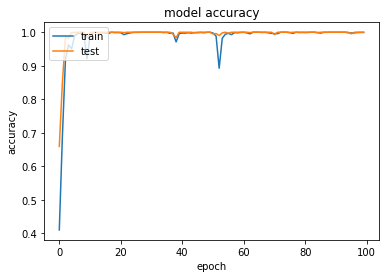

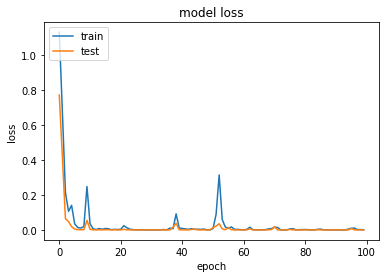

In [6]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### testing for face CNN

In [7]:
data_root_orig = './testData'
data_root = pathlib.Path(data_root_orig)
print(data_root)
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# label_names.remove('.ipynb_checkpoints')
print(label_names)
label_to_index = dict((name, i) for i, name in enumerate(label_names))

testData
['GabyNg', 'LeeSeng', 'XiaoYan']


In [8]:
test_set_df = pd.read_csv('./test_GabyNg_face_set.csv')
print(len(test_set_df))

21


In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0,
    height_shift_range=0,
    rotation_range=0,
    zoom_range=0,
    shear_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')
test_generator = datagen.flow_from_dataframe(dataframe=test_set_df, x_col="filename", y_col="label",
                                                  class_mode="categorical", target_size=(pixel, pixel),
                                                  shuffle=False,
                                                  batch_size=batch_size)

Found 21 validated image filenames belonging to 3 classes.


In [10]:
pred = model.predict(test_generator)

In [13]:
import sklearn.metrics as metrics
predout = np.argmax(pred, axis=1)
testout = test_set_df['label'].apply(lambda x: label_to_index[x]).values
print("Test result for CNN using face only images in rescale data generator")
print('Batch size is:', batch_size)
print('testout:', testout)
print('predout:', predout)

testScores = metrics.accuracy_score(testout, predout)
confusion = metrics.confusion_matrix(testout, predout)
print("Best accuracy (on test data set): %.2f%%" % (testScores * 100))
print(metrics.classification_report(testout, predout, labels=[0,1,2],target_names=label_names, digits=4))
print(confusion)

test result for CNN using face only images in rescale data generator
Batch size is: 128
testout: [0 0 0 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1]
predout: [1 0 0 0 0 2 2 2 2 2 2 2 2 0 1 0 1 1 1 2 1]
Best accuracy (on test data set): 80.95%
              precision    recall  f1-score   support

      GabyNg     0.6667    0.8000    0.7273         5
     LeeSeng     0.8333    0.7143    0.7692         7
     XiaoYan     0.8889    0.8889    0.8889         9

    accuracy                         0.8095        21
   macro avg     0.7963    0.8011    0.7951        21
weighted avg     0.8175    0.8095    0.8105        21

[[4 1 0]
 [1 5 1]
 [1 0 8]]


In [14]:
model.save('model/face_cnn_rescale_model.h5')